In [1]:
import torch
from torch import nn
from dataset import yolo_dataset
from model import YOLO
from create_dataset import create_image
from torchvision import transforms
from matplotlib.pyplot import imshow
from torch.functional import F
from PIL import Image, ImageDraw
from utils import predict, desenhar_anotacoes

In [2]:
ch = torch.load('./models/checkpoint_9_epochs.pth', map_location=torch.device('cpu'))
model = YOLO(ch['S'], ch['C'], ch['B'], ch['IMG_SIZE'], ch['architecture_config'])
print (model.load_state_dict(ch['state_dict']))

transformer = transforms.Compose([
    transforms.Resize((ch['IMG_SIZE'], ch['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

<All keys matched successfully>


[[0.382394, 0.5082219243049622, 0, 36.29275713648115, 112.05791959592275, 75.27885992612157, 156.56388029881887], [0.38569817, 0.5112755298614502, 0, 48.31417438707181, 116.29151305982046, 87.4423474552376, 156.24431524106436], [0.4392758, 0.502346932888031, 1, 39.23467074121748, 119.32867699249513, 75.8287771471909, 163.27215927227266], [0.40764865, 0.5159651041030884, 1, 45.30166415630706, 120.12296331620641, 83.79404349385628, 165.03056550717778]]


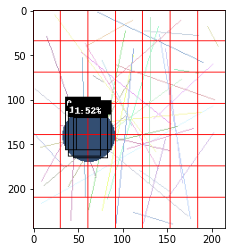

In [3]:
img_pil, bbox_true = create_image(1)
img_pil, bbox_predict = predict(model, img_pil, transformer, prob_threshold=0.2, print_grid=True)
imshow(img_pil)
print (bbox_predict)